# Navier-Stokes with a pivot-fixed falling flat plate 
## Using `Whirl` and `Dyn3d`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

include(Pkg.dir("Dyn3d")*"/src/Dyn3d.jl")
using Dyn3d

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

## <span style="color:blue"> Set up rigid body with Dyn3d

In [101]:
include(Pkg.dir("Dyn3d")*"/src/config_files/2dLink.jl")

Config info set up.


#### Build joint-body chain

In [102]:
# build joint-body chain
bodys, joints, system = BuildChain(config_bodys, config_joints, 
                                   config_system)
bd = BodyDyn(bodys, joints, system)

#### Initialize rigid body system state

In [103]:
# init system
bd, soln = InitSystem!(bd)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bd.bs));

This is a 4 body-joint system.
System is fixed in space


#### Set up HERKBody object

In [104]:
herkbody = Dyn3d.HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
                (HERKFuncf,HERKFuncgti), (UpdatePosition!,UpdateVelocity!))

Order-3 HERK integrator.


#### Genrate body grid points and get linear velocity on in

In [105]:
# generate body points and fit it into 2d, which each items choose [1,3] for 2d cases in [x,y]
# note: np = (# of points on 1d plate - 1)*4+1. So np=101 has 26 points
# and np=201 has 51 points, np=49 has 13 points

bgs = GenerateBodyGrid(bd; np=201)
bgs = CutOut2d(bd,bgs)
bgs = AcquireBodyGridKinematics(bd,bgs)

# generate the format for fluid interface
coord = hcat(bgs[1].q_i...)'[:,[1,2]]
motion = hcat(bgs[1].v_i...)'[:,[1,2]]
for i = 2:length(bgs)
    coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
    motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,2]]]
end

#### Get body verts for plotting

In [106]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, solns[1].qJ)
vs₀ = VertsHistory(sys.nbody, bs);

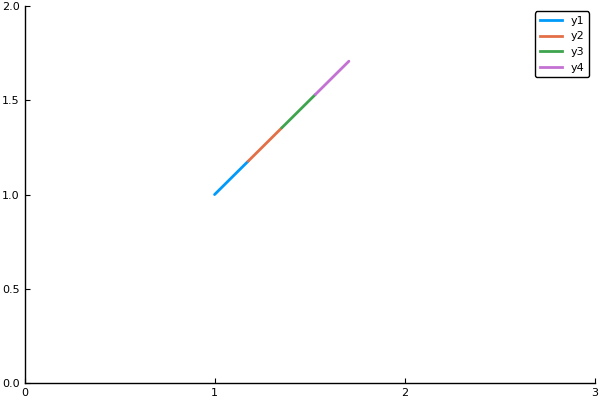

In [107]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,3), ylims=(0,2))

## <span style="color:blue"> Set up fluid solver with Whirl </span>

Set the flow parameters

In [108]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set the domain size and time step size

In [109]:
nx = 152; ny = 102;
Ly = 2.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny));
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:3.0100000000000002, -0.01:0.02:2.0100000000000002)

#### Set up the Navier-Stokes  problem type

In [110]:
X̃ = VectorData(coord)
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, isstore = true, isstatic = false)

Navier-Stokes system on a grid of size 152 x 102

#### Set up initial conditions

In [111]:
t = 0.0
w₀ .= 0.0
tf = 20*Δt
T = Δt:Δt:tf
fx = Float64[]
fy = Float64[]
thist = []
uhist = []
tsample = 0.02;

## <span style="color:blue"> Preparation for Time Marching </span>

#### Constants for coupling

In [112]:
tol = 5e-4
soln.dt = Δt
ω = (config_bodys[1].ρ)/(1.0+config_bodys[1].ρ)

0.5

#### Helper function to convert VectorData type

In [113]:
import Base: +,*
function (+)(a::VectorData, b::VectorData)
    c = VectorData(a)
    c.u .= a.u .+ b.u
    c.v .= a.v .+ b.v
    return c
end

function (*)(ω::T, a::VectorData) where T<: Real
    c = VectorData(a)
    c.u .= ω.*a.u
    c.v .= ω.*a.v
    return c
end

function (*)(a::VectorData,ω::T) where T<: Real
    c = VectorData(a)
    c.u .= ω.*a.u
    c.v .= ω.*a.v
    return c
end

* (generic function with 287 methods)

#### Create Body solver object of type HerkBody

In [114]:
# construct body solver
herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
            (HERKFuncf,HERKFuncgti),
            (UpdatePosition!,UpdateVelocity!))

Order-3 HERK integrator.


#### Create Fluid solver object of type IFHERK

In [115]:
u = (w₀,[coord motion][:])
f = (VectorData(X̃),Vector{Float64}())

# number of constraints (4*total number of body points)
nc = length(u[2])

# construct fluid solver with uniform constant free stream
ifherk = Whirl.IFHERK(u,f,sys.Δt,
                ((t,u) -> Systems.plan_intfact(t,u,sys),
                 (t,u) -> eye(nc)),
                (u,t) -> Whirl.plan_constraints(u,t,sys),
                ((u,t) -> Whirl.r₁(u,t,sys),
                 (u,t) -> Whirl.r₂(u,t,sys)),
                tol=1e-3,rk=Whirl.TimeMarching.RK31,
                isstored=true,isstaticconstraints=false)

Order-3 IF-HERK integrator with
   State of type Tuple{Whirl.Fields.Nodes{Whirl.Fields.Dual,152,102},Array{Float64,1}}
   Force of type Tuple{Whirl.Fields.VectorData{101},Array{Float64,1}}
   Time step size 0.01


## <span style="color:blue"> Time Marching! </span>

In [116]:
@time for t in T

    cnt = 1
    fᵢ = f[1]*Δx^2

    # record body info
    soln_buffer = deepcopy(soln)
    bd_buffer = deepcopy(bd)
    bgs_buffer = deepcopy(bgs)

    # record fluid info
    u_buffer = deepcopy(u)
    t_buffer = t

    while true

        # get body state of the last timestep
        soln = deepcopy(soln_buffer)
        bd = deepcopy(bd_buffer)
        bgs = deepcopy(bgs_buffer)

        # integrate body force for body solver
        for i = 1:bgs[1].np
            bgs[1].f_ex3d[i][1] = fᵢ.u[i]
            bgs[1].f_ex3d[i][3] = fᵢ.v[i]
        end
        bgs = IntegrateBodyGridDynamics(bd,bgs)
        f_exi = zeros(bd.sys.nbody,6)
        for i = 1:bd.sys.nbody
            f_exi[i,:] = bgs[i].f_ex6d
        end

        # advance body solver for one step
        soln, bd = herkbody(soln, bd; _isfixedstep=true, f_exi=f_exi);

        # acquire vel and coord of body points for fluid computation
        coord = hcat(bgs[1].q_i...)'[:,[1,2]]
        motion = hcat(bgs[1].v_i...)'[:,[1,2]]
        for i = 2:length(bgs)
            coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
            motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,2]]]
        end

        # get fluid state of the last timestep
        u = deepcopy(u_buffer)
        t = t_buffer

        # advance fluid solver for one step
        u = (u[1],[coord motion][:])
        t, u, f = ifherk(t,u)

        # check if converge
        ϵ = norm(f[1]*Δx^2 - fᵢ)
        if ϵ < tol break end

#         println("proposed fy:", sum(fᵢ.v))
#         println("corrected fy:", sum(f[1].v)*Δx^2)
        
        # if not converge, use relaxation
        fᵢ = (1-ω)*fᵢ + ω*(f[1])*Δx^2
        
#         println("relaxation fy:", sum(fᵢ.v),"\n")
        println("count ",cnt,", ϵ = ",ϵ);
        cnt += 1

    end

    # converged for this timestep
    print("time = ", t, " converged through ", cnt, " iterations\n")
    
    # record body info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bd.bs))

    # record fluid info
    push!(thist,t)
    push!(fx,sum(fᵢ.u))
    push!(fy,sum(fᵢ.v))
    push!(uhist,deepcopy(u))
    
end

println("solution completed through time t = ",t)

count 1, ϵ = 657.2948758450736

count 2, ϵ = 328.6474379225368

count 3, ϵ = 164.3237189612684

count 4, ϵ = 82.1618594806342

count 5, ϵ = 41.08092974031709

count 6, ϵ = 20.54046487015854

count 7, ϵ = 10.270232435079272

count 8, ϵ = 5.13511621753962

count 9, ϵ = 2.567558108769817

count 10, ϵ = 1.2837790543849255

count 11, ϵ = 0.6418895271924617

count 12, ϵ = 0.3209447635962359

count 13, ϵ = 0.1604723817981096

count 14, ϵ = 0.08023619089905797

count 15, ϵ = 0.04011809544953707

count 16, ϵ = 0.020059047724764592

count 17, ϵ = 0.010029523862386137

count 18, ϵ = 0.005014761931198142

count 19, ϵ = 0.0025073809655985118

count 20, ϵ = 0.001253690482813772

count 21, ϵ = 0.0006268452413963555

time = 0.02 converged through 22 iterations
count 1, ϵ = 768.885887424546

count 2, ϵ = 384.442943712273

count 3, ϵ = 192.22147185613653

count 4, ϵ = 96.11073592806827

count 5, ϵ = 48.05536796403413

count 6, ϵ = 24.027683982017063

count 7, ϵ = 12.013841991008533

count 8, ϵ = 6.00692

LoadError: [91mInterruptException:[39m

#### Get body verts history

In [117]:
@get bd (bs, js, sys)

# get verts info based on this regular grid solution
vshist = []
for i = 1:length(solns)
    bs, js, sys = UpdatePosition!(bs, js, sys, solns[i].qJ)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field and body

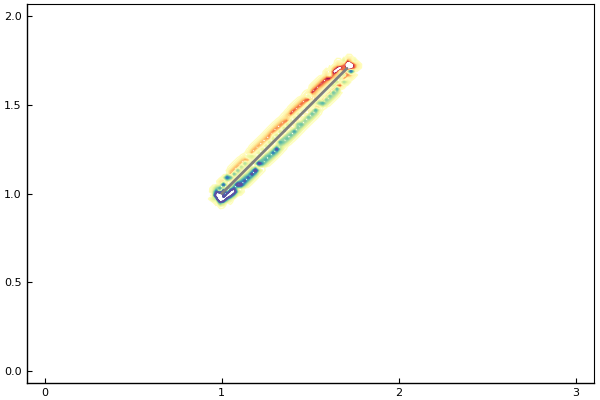

In [128]:
p1 = plot(xg,yg,uhist[1][1],levels=linspace(-1,1,80))
for i = 1:sys.nbody
    plot!(p1,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="grey")
end
p1

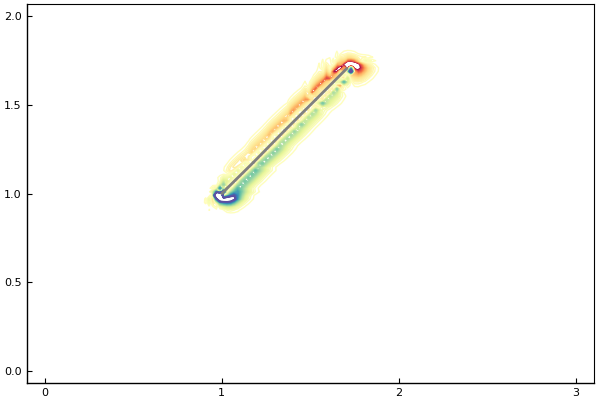

In [125]:
p1 = plot(xg,yg,uhist[end][1],levels=linspace(-1,1,80))
for i = 1:sys.nbody
    plot!(p1,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="grey")
end
p1

#### Gif!

In [130]:
@gif for j = 1:length(uhist)
    p1 = plot(xg,yg,uhist[1][1],levels=linspace(-1,1,80))
    for i = 1:sys.nbody
        plot!(p1,vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="grey")
    end
    plot!(xlims=(0.5,2.5), ylims=(0,2))
end

INFO: Saved animation to /media/ruizhi/Seagate Expansion Drive/Research/Dyn3d.jl/notebook/tmp.gif


Plots.AnimatedGif("/media/ruizhi/Seagate Expansion Drive/Research/Dyn3d.jl/notebook/tmp.gif")

#### force history

In [121]:
px = plot(thist,2*fx,ylim=(min(2*fx),max(2*fx)),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(min(2*fy),max(2*fy)),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

LoadError: [91mMethodError: no method matching min(::Array{Float64,1})[0m
Closest candidates are:
  min(::AbstractArray{T1<:Real,N} where N, [91m::Real[39m) where T1<:Real at deprecated.jl:56
  min(::AbstractArray{T1<:Real,N} where N, [91m::AbstractArray{T2<:Real,N} where N[39m) where {T1<:Real, T2<:Real} at deprecated.jl:56
  min(::Any, [91m::Any[39m) at operators.jl:361
  ...[39m

In [122]:
fx

7-element Array{Float64,1}:
 -49.3108  
   1.11953 
   1.08678 
   1.0559  
   1.03045 
   1.01076 
   0.996222

In [123]:
fy

7-element Array{Float64,1}:
 42.6624  
 -0.539219
 -0.596289
 -0.643854
 -0.680944
 -0.710155
 -0.734222